In [155]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
'''LSTMで時系列予測を行う'''

'LSTMで時系列予測を行う'

In [156]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
print(keras.backend.backend())

tensorflow


In [157]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

In [158]:
# 乱数固定
SEED = 20241001
keras.utils.set_random_seed(SEED)
import os
os.environ['PYTHONHASHSEED'] = str(SEED)
import numpy as np
np.random.seed(SEED)
import random
random.seed(SEED)
import tensorflow as tf
tf.random.set_seed(SEED)

In [159]:
# 定数
BATCH_SIZE = 12	# ミニバッチのサイズ
EPOCHS = 20	# 学習回数(1〜)
N_TEST = 12	# 最後のこの月数分を予測する
TIMESTEPS_IN = 12	# 入力時系列長
TIMESTEPS_OUT = 1	# 出力時系列長

In [160]:
# データを生成する関数
def make_data(X):
    # 念のためnp.arrayに変換
    x = np.asarray(X) if X.ndim	> 1 else np.asarray(X).reshape(-1, 1)

    # x+yの配列に変換
    x = np.asarray([x[i:i+TIMESTEPS_IN+TIMESTEPS_OUT] for i in range(len(x)-TIMESTEPS_IN-TIMESTEPS_OUT+1)])

    # BATCH_SIZEの倍数になるよう先頭を切り捨て
    x = np.asarray(x[len(x)%BATCH_SIZE:])

    # xとyに分離
    x_data = x[:, :TIMESTEPS_IN].reshape(-1, TIMESTEPS_IN, x.shape[-1])
    y_data = x[:, -TIMESTEPS_OUT:].reshape(-1, TIMESTEPS_OUT, x.shape[-1])

    # train, testに分割
    x_train = x_data[:-N_TEST]
    y_train = y_data[:-N_TEST]
    x_test = x_data[-N_TEST:]
    y_test = y_data[-N_TEST:]

    return (x_train, y_train), (x_test, y_test)

In [161]:
# モデルを構築する関数
def make_model(layers, stateful, units, dropout):
    inputs = keras.layers.Input(batch_shape=(BATCH_SIZE, TIMESTEPS_IN, 1))
    x = inputs
    for i in range(layers):
        x = keras.layers.LSTM(units=units, stateful=stateful, return_sequences=(i < layers-1))(x)
        x = keras.layers.LayerNormalization(epsilon=1e-6)(x)

    x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.Dense(TIMESTEPS_OUT)(x)
    outputs = keras.layers.Reshape(target_shape=(TIMESTEPS_OUT, 1))(x)

    model = keras.models.Model(inputs=inputs, outputs=outputs)
    return model

In [162]:
# データ読み込み
df = pd.read_csv('data/international-airline-passengers.csv', engine='python', skipfooter=3)
df_p = df['passengers']

In [163]:
# 標準化
std = df_p.std()
mean = df_p.mean()
df_s = (df_p - mean) / std

In [164]:
# データ整形
(x_train, y_train), (x_test, y_test) = make_data(df_s)
print(f'{x_train.shape=}, {y_train.shape=}, {x_test.shape=}, {y_test.shape=}')

x_train.shape=(108, 12, 1), y_train.shape=(108, 1, 1), x_test.shape=(12, 12, 1), y_test.shape=(12, 1, 1)


In [165]:
# ハイパーパラメータ
layers = 1 # LSTMレイヤの数
stateful = True	# LSTMをstatefulにするかどうか(False/True)
units = 40	# LSTM層の出力ユニット数(1〜)
dropout = 0.05361584483320092	# LSTM層からの出力のドロップアウト率(0.0〜1.0)
learning_rate = 0.01841361563364898	# 学習率(0<)

In [166]:
# モデル構築
model = make_model(
    layers=layers,
    stateful=stateful,
    units=units,
    dropout=dropout,
)

In [167]:
# 学習ループ構築
model.compile(optimizer=keras.optimizers.AdamW(learning_rate=learning_rate, clipnorm=0.001), loss=keras.losses.LogCosh(), metrics=['mse'])

In [168]:
# モデルの表示
keras.utils.plot_model(model, to_file='model.png')
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (12, 12, 1)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (12, 40)               │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_9           │ (12, 40)               │            80 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (12, 40)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (12, 1)                │            41 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_7 (Reshape)             │ (12, 1, 1)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,841 (26.72 KB)

 Trainable params: 6,841 (26.72 KB)

 Non-trainable params: 0 (0.00 B)

In [169]:
# モデル内の全レイヤのreset_stetesを呼び出す
def reset_states(model):
    for layer in model.layers:
        if hasattr(layer, 'reset_states'):
            layer.reset_states()

In [170]:
# エポック終了毎にstatesをリセットするコールバック関数
callback = keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: reset_states(model))

In [171]:
# 学習
model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0, shuffle=False, callbacks=[callback])

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 2.1621 - mse: 12.9840
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3061 - mse: 0.7361 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5494 - mse: 1.4471 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3484 - mse: 0.8261 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1545 - mse: 0.3381 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0838 - mse: 0.1812 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1669 - mse: 0.3683 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0541 - mse: 0.1134 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2158 - mse: 0.4818 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0364 - mse: 0.0751 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0261 - mse: 0.0538 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3027 - mse: 0.6853 
Epoch 13/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.02

In [172]:
# 予測
p_train = model.predict(x_train, batch_size=BATCH_SIZE)
p_test = model.predict(x_test, batch_size=BATCH_SIZE)
print(f'{p_train.shape=}, {p_test.shape=}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
p_train.shape=(108, 1, 1), p_test.shape=(12, 1, 1)


In [173]:
# 精度を計算
loss = mean_squared_error(y_train.flatten(), p_train.flatten())
test_loss = mean_squared_error(y_test.flatten(), p_test.flatten())
print(f'{loss=}, {test_loss=}')

loss=0.11020018478990669, test_loss=0.4829442014005704


In [174]:
# 横軸
time = range(len(df))

In [175]:
# 1次元にし、標準化を元に戻す
p_train = p_train[:,-1,:].flatten() * std + mean
p_test = p_test[:,-1,:].flatten() * std + mean

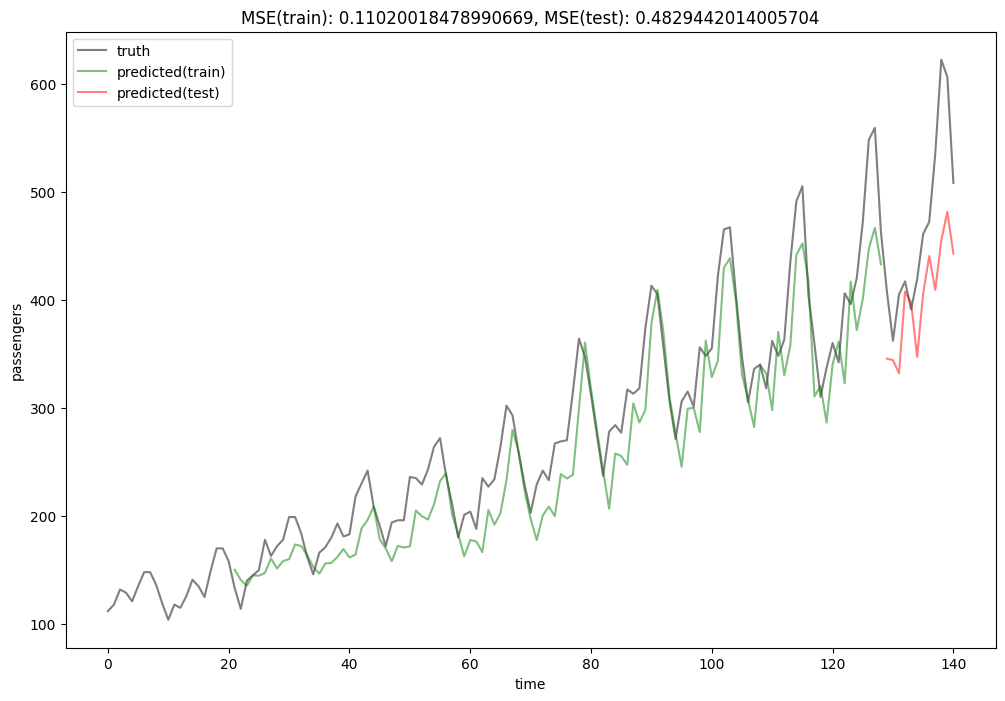

In [176]:
# グラフの描画およびファイル保存
fig = plt.figure(figsize=(12, 8))
plt.subplot(111)
plt.plot(time, df_p, color='k', label='truth', alpha=0.5)
plt.plot(time[-len(p_train)-len(p_test):-len(p_test)], p_train, color='g', label='predicted(train)', alpha=0.5)
plt.plot(time[-len(p_test):], p_test, color='r', label='predicted(test)', alpha=0.5)
plt.xlabel('time')
plt.ylabel('passengers')
plt.title(f'MSE(train): {loss}, MSE(test): {test_loss}')
#plt.legend(bbox_to_anchor=(0, 0), loc='upper left', borderaxespad=0)
plt.legend()
plt.subplots_adjust(hspace=0.5)
plt.savefig('plot.png') # ファイル出力
plt.show() # コマンドラインからの実行の場合に描画する(jupyterの場合は既に描画済みなので何も出ません)